# Estimation of obesity levels based on habits and physical condition

In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from statistics import mean
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

In [11]:
df = pd.read_excel('https://github.com/lpanfilova/ML_health_risk_prediction/raw/1f7cae84904f79a9acd090e44eaa8915c0866017/ObesityDataSet_raw_and_data_sinthetic.xlsx')

# Drop the header row from data
df = df.reindex(df.index.drop(0))
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II
5,Male,29.0,1.62,53.0,no,yes,2.0,3.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Automobile,Normal_Weight


## Data Cleaning and preparation

In [12]:
# Check null values and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2110 entries, 1 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2110 non-null   object 
 1   Age                             2110 non-null   float64
 2   Height                          2110 non-null   float64
 3   Weight                          2110 non-null   float64
 4   family_history_with_overweight  2110 non-null   object 
 5   FAVC                            2110 non-null   object 
 6   FCVC                            2110 non-null   float64
 7   NCP                             2110 non-null   float64
 8   CAEC                            2110 non-null   object 
 9   SMOKE                           2110 non-null   object 
 10  CH2O                            2110 non-null   float64
 11  SCC                             2110 non-null   object 
 12  FAF                             21

In [13]:
df.describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,2110.000000,2110.000000,2110.000000,2110.000000,2110.000000,2110.000000,2110.000000,2110.000000
mean,24.314170,1.701716,86.596762,2.419242,2.685479,2.008015,1.010777,0.657704
std,6.347063,0.093310,26.192761,0.533975,0.778193,0.613099,0.850509,0.609026
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.946718,1.630000,65.620230,2.000000,2.658689,1.582010,0.127654,0.000000
50%,22.783646,1.700563,83.000000,2.386464,3.000000,2.000000,1.000000,0.625350
75%,26.000000,1.768479,107.456672,3.000000,3.000000,2.478129,1.666821,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


In [14]:
# Change data types
df['Age'] = df['Age'].astype(float).apply(np.floor).astype(int)
df['Height'] = df['Height'].astype(float)
df['Weight'] = df['Weight'].astype(float)

# astype(object) here is for easy one-hot encoding in future 
df['FCVC'] = df['FCVC'].astype(float).apply(np.floor).astype(int).astype(object)
df['NCP'] = df['NCP'].astype(float).apply(np.floor).astype(int).astype(object)
df['CH2O'] = df['CH2O'].astype(float).apply(np.floor).astype(int).astype(object)
df['FAF'] = df['FAF'].astype(float).apply(np.floor).astype(int).astype(object)
df['TUE'] = df['TUE'].astype(float).apply(np.floor).astype(int).astype(object)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2110 entries, 1 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2110 non-null   object 
 1   Age                             2110 non-null   int32  
 2   Height                          2110 non-null   float64
 3   Weight                          2110 non-null   float64
 4   family_history_with_overweight  2110 non-null   object 
 5   FAVC                            2110 non-null   object 
 6   FCVC                            2110 non-null   object 
 7   NCP                             2110 non-null   object 
 8   CAEC                            2110 non-null   object 
 9   SMOKE                           2110 non-null   object 
 10  CH2O                            2110 non-null   object 
 11  SCC                             2110 non-null   object 
 12  FAF                             21

In [16]:
# Values in columns Gender, family_history_with_overweight, FAVC, FCVC, NCP, CAEC, SMOKE, CH2O, SCC,
# FAF, TUE, CALC, MTRANS should be categorical. Checking unique values:
print(df['Gender'].unique())
print(df['family_history_with_overweight'].unique())
print(df['FAVC'].unique())
print(df['FCVC'].unique())
print(df['NCP'].unique())
print(df['CAEC'].unique())
print(df['SMOKE'].unique())
print(df['CH2O'].unique())
print(df['SCC'].unique())
print(df['FAF'].unique())
print(df['TUE'].unique())
print(df['CALC'].unique())
print(df['MTRANS'].unique())
print(df['NObeyesdad'].unique())

['Female' 'Male']
['yes' 'no']
['no' 'yes']
[3 2 1]
[3 1 4 2]
['Sometimes' 'Frequently' 'Always' 'no']
['yes' 'no']
[3 2 1]
['yes' 'no']
[3 2 0 1]
[0 1 2]
['Sometimes' 'Frequently' 'no' 'Always']
['Public_Transportation' 'Walking' 'Automobile' 'Motorbike' 'Bike']
['Normal_Weight' 'Overweight_Level_I' 'Overweight_Level_II'
 'Obesity_Type_I' 'Insufficient_Weight' 'Obesity_Type_II'
 'Obesity_Type_III']


In [17]:
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
1,Female,21,1.52,56.0,yes,no,3,3,Sometimes,yes,3,yes,3,0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23,1.80,77.0,yes,no,2,3,Sometimes,no,2,no,2,1,Frequently,Public_Transportation,Normal_Weight
3,Male,27,1.80,87.0,no,no,3,3,Sometimes,no,2,no,2,0,Frequently,Walking,Overweight_Level_I
4,Male,22,1.78,89.8,no,no,2,1,Sometimes,no,2,no,0,0,Sometimes,Public_Transportation,Overweight_Level_II
5,Male,29,1.62,53.0,no,yes,2,3,Sometimes,no,2,no,0,0,Sometimes,Automobile,Normal_Weight


The dataset required minimal cleaning. I converted all numerical values except age, weight and height to categorical, as the dataset was based on a survey. All features except weight and height were selected to be used in the models. After applying one-hot encoding to 13 categorical features I got 40 binary features. The age column was normalized (converted to values from 0 to 1). Finally, I split data into train and test portion, where 80% were for training and validation and 20% - for hold-out test set.

## Model and Evaluation

In [18]:
# Setting prediction target
y = df.NObeyesdad
# Encoding Labels
labelencoder = LabelEncoder()
y = labelencoder.fit_transform(df['NObeyesdad'])
# Choosing features
# We use all features except height and weight
features = ['Gender', 'Age', 'family_history_with_overweight',
           'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE',
           'CALC', 'MTRANS']
# Encoding features
x = pd.get_dummies(df[features])
# Splitting dataset into train and test data
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size= 0.2, random_state = 1)

# Scaling: applying MinMaxScaler to Age column
scaler = MinMaxScaler(feature_range = (0,1))

scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [ ]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2111 entries, 1 to 2111
Data columns (total 41 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   Age                                 2111 non-null   int64
 1   Gender_Female                       2111 non-null   uint8
 2   Gender_Male                         2111 non-null   uint8
 3   family_history_with_overweight_no   2111 non-null   uint8
 4   family_history_with_overweight_yes  2111 non-null   uint8
 5   FAVC_no                             2111 non-null   uint8
 6   FAVC_yes                            2111 non-null   uint8
 7   FCVC_1                              2111 non-null   uint8
 8   FCVC_2                              2111 non-null   uint8
 9   FCVC_3                              2111 non-null   uint8
 10  NCP_1                               2111 non-null   uint8
 11  NCP_2                               2111 non-null   uint8
 12  NCP_3 

I tried three different models on the dataset: Decision Tree, Logistic Regression and Random Forest. For every model I selected hyperparameters using grid search for improving results. I found the best hyperparameter values using cross validation and used them for training the model on the entire training dataset. Finally, models were tested on the hold-out test set.

### Decision tree

Use cross validation to find best hyperparameters for a decision tree:

In [19]:
def get_score(max_leaf_nodes, max_depth, x_train, y_train):
    model = DecisionTreeClassifier(max_leaf_nodes=max_leaf_nodes, 
                                   max_depth=max_depth, random_state = 0)
    scores = cross_val_score(model, x_train, y_train, cv=5)
    avg_score = mean(scores)
    return avg_score

In [20]:
# Compare Accuracy score with different values of max_depth, max_leaf_nodes
all_max_leaf_node_vals = list(range(2, 20)) + list(range(25, 100, 5)) \
                         + list(range(150, 1000, 50)) + list(range(1000, 10000, 100))
all_max_depth_vals = [2, 5, 10, 20, 50, 100]

all_scores_and_params = []

for max_depth in all_max_depth_vals:
  for max_leaf_nodes in all_max_leaf_node_vals:
    score = get_score(max_leaf_nodes, max_depth, x_train, y_train)
    all_scores_and_params.append((score, max_leaf_nodes, max_depth))

  print(f'Finished max_depth = {max_depth}')

all_scores = [s[0] for s in all_scores_and_params]
best_score = max(all_scores)
best_score_index = all_scores.index(best_score)
best_params = all_scores_and_params[best_score_index]

print(f'Best accuracy is {best_score} for max_leaf_nodes = {best_params[1]}, max_depth = {best_params[2]}')


Finished max_depth = 2
Finished max_depth = 5
Finished max_depth = 10
Finished max_depth = 20
Finished max_depth = 50
Finished max_depth = 100
Best accuracy is 0.7470194721963724 for max_leaf_nodes = 300, max_depth = 20


Use the best hyperparameters to train a new decision tree on the whole training data:

In [21]:
# Fit model using best tree size
dec_tree_model = DecisionTreeClassifier(max_leaf_nodes = 400, max_depth = 20, random_state = 1)
dec_tree_model.fit(x_train,y_train)

DecisionTreeClassifier(max_depth=20, max_leaf_nodes=400, random_state=1)

In [22]:
# Accuracy Score
dec_tree_model.score(x_test, y_test)

0.7748815165876777

In [23]:
print(classification_report(y_test, dec_tree_model.predict(x_test), target_names = labelencoder.classes_))

                     precision    recall  f1-score   support

Insufficient_Weight       0.83      0.74      0.78        68
      Normal_Weight       0.51      0.54      0.53        48
     Obesity_Type_I       0.73      0.77      0.75        66
    Obesity_Type_II       0.81      0.85      0.83        60
   Obesity_Type_III       1.00      1.00      1.00        64
 Overweight_Level_I       0.74      0.79      0.77        58
Overweight_Level_II       0.75      0.67      0.71        58

           accuracy                           0.77       422
          macro avg       0.77      0.77      0.77       422
       weighted avg       0.78      0.77      0.78       422



I chose to tune hyperparameters Max_leaf_nodes and Max_depth. Max_depth is the maximum depth of the tree, while max_leaf_nodes is the number of leaves in the tree. I got the best max_depth value 20 and max_leaf_nodes 400. The less these values are the better is generalization of the model, both parameters can be used to avoid overfitting.

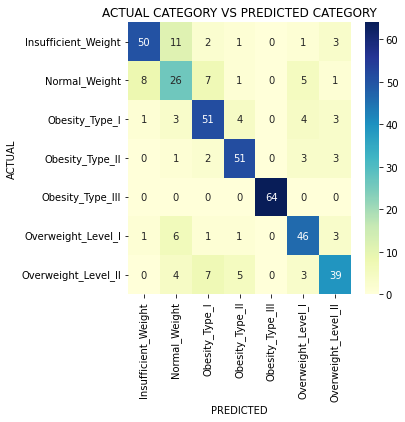

In [24]:
# Confusion Matrix
cm = confusion_matrix(y_test, dec_tree_model.predict(x_test))
fig, ax = plt.subplots(figsize = (5,5))
sns.heatmap(cm, annot = True, fmt ='d',cmap="YlGnBu", xticklabels = labelencoder.classes_,
            yticklabels = labelencoder.classes_)
plt.ylabel('ACTUAL')
plt.xlabel('PREDICTED')
ax.set_title('ACTUAL CATEGORY VS PREDICTED CATEGORY')
plt.show()

Decision tree performed on the dataset with accuracy 75%. The best precision and recall were on categories Obesity type 2 and 3, while normal weight was the most difficult to predict. These results can be visually seen on the confusion matrix. It shows how many instances of each class were predicted to belong to another class. The best result is for class Obesity Type 3 where only 1 instance was predicted incorrectly.

### Logistic Regression

In [27]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'solver': ['lbfgs', 'sag', 'newton-cg'],}]
# With grid search we tried to increase C and found out that less regulatization improves accuracy
# Therefore, we are using penalty='none'
grid_search_lr = GridSearchCV(LogisticRegression(max_iter=1000, penalty='none'), param_grid, cv=5, scoring='accuracy')
grid_search_lr.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, penalty='none'),
             param_grid=[{'solver': ['lbfgs', 'sag', 'newton-cg']}],
             scoring='accuracy')

In [28]:
print(grid_search_lr.best_params_)
print(grid_search_lr.best_score_)

{'solver': 'newton-cg'}
0.6083999086966446


In [30]:
# Creating Logistic Regression Model
log_reg_model = LogisticRegression(max_iter=1000,penalty='none',solver='sag')
log_reg_model.fit(x_train, y_train)

LogisticRegression(max_iter=1000, penalty='none', solver='sag')

In [31]:
# Accuracy Score
log_reg_model.score(x_test, y_test)

0.6208530805687204

In [32]:
# Cross validation
scores = cross_val_score(log_reg_model, x_train, y_train, cv=5)
scores

array([0.63313609, 0.61538462, 0.59467456, 0.59050445, 0.60534125])

In [33]:
print(classification_report(y_test, log_reg_model.predict(x_test), target_names = labelencoder.classes_))

                     precision    recall  f1-score   support

Insufficient_Weight       0.81      0.68      0.74        68
      Normal_Weight       0.48      0.54      0.51        48
     Obesity_Type_I       0.47      0.53      0.50        66
    Obesity_Type_II       0.56      0.90      0.69        60
   Obesity_Type_III       0.98      0.98      0.98        64
 Overweight_Level_I       0.53      0.55      0.54        58
Overweight_Level_II       0.35      0.10      0.16        58

           accuracy                           0.62       422
          macro avg       0.60      0.61      0.59       422
       weighted avg       0.61      0.62      0.60       422



For logistic regression I chose to tune hyperparameter C. This is an inverse regularization parameter. I figured out that with increasing C I am improving the accuracy of the model on a validation set. Therefore, I decided to use parameter penalty=none so no regularization is applied.

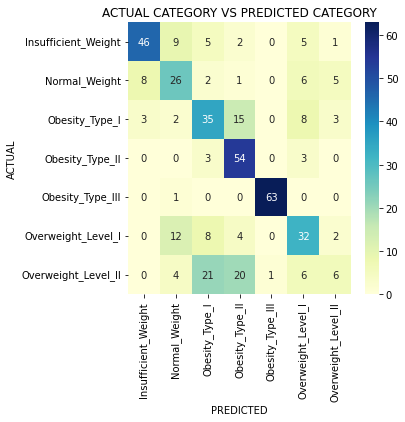

In [34]:
# Confusion Matrix
cm = confusion_matrix(y_test, log_reg_model.predict(x_test))
fig, ax = plt.subplots(figsize = (5,5))
sns.heatmap(cm, annot = True, fmt ='d',cmap="YlGnBu", xticklabels = labelencoder.classes_,
            yticklabels = labelencoder.classes_)
plt.ylabel('ACTUAL')
plt.xlabel('PREDICTED')
ax.set_title('ACTUAL CATEGORY VS PREDICTED CATEGORY')
plt.show()

Logistic Regression performed on the dataset with lower accuracy of 57%. In the confusion matrix I can see that it did a lot of false predictions on classes Overweight Level 1, 2 and Normal Weight. Class Obesity type 3 was still the easiest to predict.

### Random Forest

In [35]:
param_grid = [{'n_estimators':[500,1000,1500],
               'max_depth': [20,30, 40],
               'max_features': [3,4,5]}]
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state = 1), param_grid, cv=5, scoring='accuracy')
grid_search_rf.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1),
             param_grid=[{'max_depth': [20, 30, 40], 'max_features': [3, 4, 5],
                          'n_estimators': [500, 1000, 1500]}],
             scoring='accuracy')

In [ ]:
print(grid_search_rf.best_params_)
print(grid_search_rf.best_score_)

{'max_depth': 30, 'max_features': 4, 'n_estimators': 1000}
0.8044931785858515


In [ ]:
# Cross validation
scores = cross_val_score(ran_for_model, x_train, y_train, cv=5)
scores

array([0.78994083, 0.82248521, 0.81656805, 0.80118694, 0.79228487])

In [ ]:
ran_for_model = RandomForestClassifier(n_estimators = 1000,max_depth = 30,max_features = 4, random_state = 1)
ran_for_model.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features=4,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [ ]:
# Accuracy Score
ran_for_model.score(x_test, y_test)

0.8108747044917257

In [ ]:
print(classification_report(y_test, ran_for_model.predict(x_test), target_names = labelencoder.classes_))

                     precision    recall  f1-score   support

Insufficient_Weight       0.85      0.85      0.85        61
      Normal_Weight       0.58      0.67      0.62        45
     Obesity_Type_I       0.77      0.78      0.77        79
    Obesity_Type_II       0.92      0.89      0.91        54
   Obesity_Type_III       0.98      0.98      0.98        63
 Overweight_Level_I       0.72      0.62      0.67        61
Overweight_Level_II       0.84      0.85      0.84        60

           accuracy                           0.81       423
          macro avg       0.81      0.81      0.81       423
       weighted avg       0.81      0.81      0.81       423



For random forest I tuned Max_depth, Max_features and N_estimators (number of estimators). Number of estimators is the number of trees in the forest, higher values usually improve learning of data, and the model training was fast even with 1000 estimators. Max_features is the number of features to consider when looking for the best spit, in my case the best number of features is 4. Max_features can be used to control overfitting.

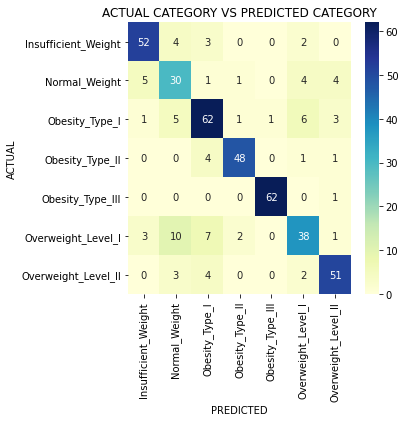

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, ran_for_model.predict(x_test))
fig, ax = plt.subplots(figsize = (5,5))
sns.heatmap(cm, annot = True, fmt ='d',cmap="YlGnBu", xticklabels = labelencoder.classes_,
            yticklabels = labelencoder.classes_)
plt.ylabel('ACTUAL')
plt.xlabel('PREDICTED')
ax.set_title('ACTUAL CATEGORY VS PREDICTED CATEGORY')
plt.show()

Random forest performs the best on the data with accuracy score 81%. Similar to a decision tree the highest precision and recall can be seen for classes Obesity type 2 and 3. On the confusion matrix it can be seen that normal weight is still the hardest to predict.

### Voting Classifier

In [ ]:
from sklearn.svm import SVC

svc = SVC()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()

classifiers = [('svc',svc),('rf',rf, ),('dt',dt)]
vot = VotingClassifier(estimators = classifiers, voting ='hard')



In [ ]:
vot.fit(x_train, y_train)
# Cross validation
scores = cross_val_score(vot, x_train, y_train, cv=5)
scores

array([0.79585799, 0.84319527, 0.79585799, 0.79228487, 0.77448071])

In [ ]:
from sklearn.metrics import accuracy_score
#Accuracy score:
for classifier in (svc, rf, dt, vot):
  classifier.fit(x_train, y_train)
  y_pred = classifier.predict(x_test)
  print(classifier.__class__.__name__, accuracy_score(y_test, y_pred))

SVC 0.6997635933806147
RandomForestClassifier 0.8037825059101655
DecisionTreeClassifier 0.7754137115839244
VotingClassifier 0.7919621749408984
